In [9]:
import numpy as np
import matplotlib
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import pandas as pd
from typing import List, Tuple
import numpy.typing as npt
import tensorflow as tf
import tensorflow_model_optimization as tfmot
import Quantization
from keras.engine.functional import Functional
# plt.style.use('bmh')
OUTPUTS_DIR = "./outputs/"
PLT_SAVE_PATH = './images/'

In [10]:
def convert_position(x : int) -> Tuple[int, int]:
    if x == 0:
        return (0,0)
    elif x == 1:
        return (0,1)
    else:
        return (x//2, x%2)

def pyplot_backend_change(extension : str) -> Tuple[str, int]:
    if extension == 'pgf':
        save_path = 'C:/Users/rosal/Documents/Files/Master Project/Report/'
        fig_size = 5
        matplotlib.use("pgf")
        matplotlib.rcParams.update({
            "pgf.texsystem": "pdflatex",
            'font.family': 'serif',
            'text.usetex': True,
            'pgf.rcfonts': False,
        })
    else:
        save_path = './images/'
        fig_size = 8
        matplotlib.use("module://matplotlib_inline.backend_inline")
        matplotlib.rcParams.update({
            "pgf.texsystem": "xelatex",
            'font.family': 'sans-serif',
            'text.usetex': False,
            'pgf.rcfonts': True,
        })
    return save_path, fig_size

In [51]:
# Accuracy degradation model: 'final 01', data: 'QSplit_m2_quantized_2023-05-22.csv'
EXTENSION = 'pgf'
[save_path, fig_size] = pyplot_backend_change(EXTENSION)
print("Matploblib backend:", matplotlib.get_backend())

# Constants and data loading
DATA_PATH = OUTPUTS_DIR + 'QSplit_m2_quantized_2023-05-22.csv'
SAVE_NAME = 'Q_Split_final_acc_degradation.' + EXTENSION
N_FLIPS = 4
df = pd.read_csv(DATA_PATH)

# Graphs definition
ax : List[List[plt.Axes]]
fig, ax = plt.subplots(N_FLIPS//2, 2, figsize = (fig_size, fig_size))
fig.tight_layout(h_pad = 3.5, rect=[0, 0, 1, 1])
# fig.suptitle('Accuracy degradation for QSplit 2-part quantized model')
yaxis_major_locators = [.2, .4, .5, .8]
yaxis_minors_locators = [4, 4, 4, 2]
decimals = [1, 1, 1, 1]

for i in range(1, N_FLIPS + 1):
    ax[convert_position(i - 1)].yaxis.set_major_formatter(ticker.PercentFormatter(decimals = decimals[i - 1]))
    condition = (df['layer_key'].notna()) & (df['n_bits_flipped'] == i)
    ax[convert_position(i - 1)].plot(df.loc[condition]['bit_disrupted'], pd.to_numeric(df.loc[condition]['q_aware_test_acc_degradation'])*100, '.', alpha = 0.05, markersize = 4)
    ax[convert_position(i - 1)].set_title('Bits flipped per image: ' + str(i))
    ax[convert_position(i - 1)].set_xlabel('Bit position disrupted per integer')
    ax[convert_position(i - 1)].xaxis.set_major_locator(ticker.MultipleLocator(5))
    ax[convert_position(i - 1)].xaxis.set_minor_locator(ticker.AutoMinorLocator(5))
    ax[convert_position(i - 1)].yaxis.set_major_locator(ticker.MultipleLocator(yaxis_major_locators[i - 1]))
    ax[convert_position(i - 1)].yaxis.set_minor_locator(ticker.AutoMinorLocator(yaxis_minors_locators[i - 1])) 
    ax[convert_position(i - 1)].grid(which = 'major', linestyle = '-', alpha = 0.50, linewidth = 0.50)
    ax[convert_position(i - 1)].grid(which = 'minor', linestyle = ':', alpha = 0.25, linewidth = 0.25)

    # Trend lines
    averages = []
    stds = []
    bits_array = np.unique(df.loc[condition]['bit_disrupted'])
    for j in bits_array:
        new_condition = condition & (df['bit_disrupted'] == j)
        averages.append(pd.to_numeric(df.loc[new_condition]['q_aware_test_acc_degradation']).mean())
        stds.append(pd.to_numeric(df.loc[new_condition]['q_aware_test_acc_degradation']).std())
    averages = np.array(averages)
    ax[convert_position(i - 1)].plot(bits_array, averages*100, alpha = 0.95, color = 'purple', linewidth = 1.5)
    ax[convert_position(i - 1)].plot(bits_array, (averages + stds)*100, '--', alpha = 0.95, color = 'green', linewidth = 0.75)
    ax[convert_position(i - 1)].plot(bits_array, (averages - stds)*100, '--', alpha = 0.95, color = 'green', linewidth = 0.75)

plt.savefig(save_path + SAVE_NAME, bbox_inches = 'tight')
plt.show()
plt.close()

Matploblib backend: pgf


C:\Users\rosal\AppData\Local\Temp\ipykernel_11220\3660623126.py:48: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  plt.show()


In [50]:
# Loss model: 'final 01' data: 'QSplit_m2_quantized_2023-05-22.csv'
EXTENSION = 'pgf'
[save_path, fig_size] = pyplot_backend_change(EXTENSION)
print("Matploblib backend:", matplotlib.get_backend())

# Constants and data loading
DATA_PATH = OUTPUTS_DIR + 'QSplit_m2_quantized_2023-05-22.csv'
SAVE_NAME = 'Q_Split_final_loss.' + EXTENSION
N_FLIPS = 4
df = pd.read_csv(DATA_PATH)

# Graphs definition
ax : List[List[plt.Axes]]
fig, ax = plt.subplots(N_FLIPS//2, 2, figsize = (fig_size, fig_size))
fig.tight_layout(h_pad = 3.5, rect=[0, 0, 1, 1])
# fig.suptitle('Loss for QSplit 2-part quantized model')
yaxis_major_locators = [.005, .01, .02, .02]
yaxis_minors_locators = [2, 4, 4, 4]

for i in range(1, N_FLIPS + 1):
    condition = (df['layer_key'].notna()) & (df['n_bits_flipped'] == i)
    ax[convert_position(i - 1)].plot(df.loc[condition]['bit_disrupted'], pd.to_numeric(df.loc[condition]['q_aware_test_loss']), '.', alpha = 0.05, markersize = 4)
    ax[convert_position(i - 1)].set_title('Integer positions flipped per image: ' + str(i))
    ax[convert_position(i - 1)].set_xlabel('Bit position disrupted per integer')
    ax[convert_position(i - 1)].xaxis.set_major_locator(ticker.MultipleLocator(5))
    ax[convert_position(i - 1)].xaxis.set_minor_locator(ticker.AutoMinorLocator(5))
    ax[convert_position(i - 1)].yaxis.set_major_locator(ticker.MultipleLocator(yaxis_major_locators[i - 1]))
    ax[convert_position(i - 1)].yaxis.set_minor_locator(ticker.AutoMinorLocator(yaxis_minors_locators[i - 1])) 
    ax[convert_position(i - 1)].grid(which = 'major', linestyle = '-', alpha = 0.50, linewidth = 0.50)
    ax[convert_position(i - 1)].grid(which = 'minor', linestyle = ':', alpha = 0.25, linewidth = 0.25)

    # Trend lines
    averages = []
    stds = []
    bits_array = np.unique(df.loc[condition]['bit_disrupted'])
    for j in bits_array:
        new_condition = condition & (df['bit_disrupted'] == j)
        averages.append(pd.to_numeric(df.loc[new_condition]['q_aware_test_loss']).mean())
        stds.append(pd.to_numeric(df.loc[new_condition]['q_aware_test_loss']).std())
    averages = np.array(averages)
    ax[convert_position(i - 1)].plot(bits_array, averages, alpha = 0.95, color = 'purple', linewidth = 1.5)
    ax[convert_position(i - 1)].plot(bits_array, (averages + stds), '--', alpha = 0.95, color = 'green', linewidth = 0.75)
    ax[convert_position(i - 1)].plot(bits_array, (averages - stds), '--', alpha = 0.95, color = 'green', linewidth = 0.75)

plt.savefig(save_path + SAVE_NAME, bbox_inches = 'tight')
plt.show()
plt.close()

Matploblib backend: pgf


C:\Users\rosal\AppData\Local\Temp\ipykernel_11220\3350062712.py:46: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  plt.show()


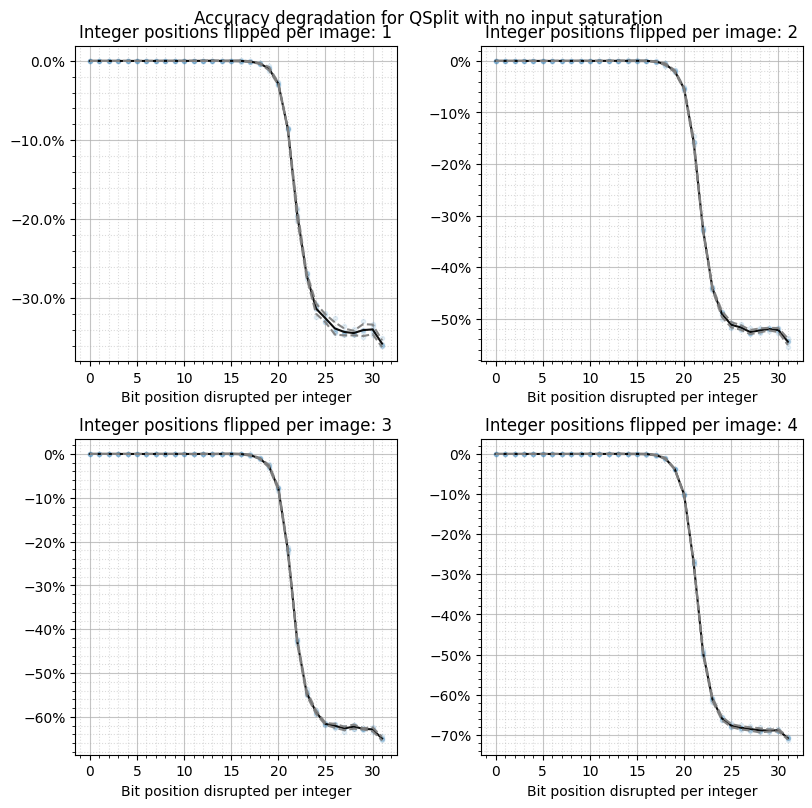

In [4]:
# Accuracy degradation model: 'final 01' data: 'QSplit_no_input_saturation_2023-06-29.csv'
DATA_PATH = OUTPUTS_DIR + 'QSplit_no_input_saturation_2023-06-29.csv'
# DATA_PATH = OUTPUTS_DIR + 'QSplit_no_input_saturation_2023-05-23.csv'
SAVE_NAME = 'QSplit No Input Saturation Accuracy 2023-06-29.png'
N_FLIPS = 4
df = pd.read_csv(DATA_PATH)

ax : List[List[plt.Axes]]
fig, ax = plt.subplots(N_FLIPS//2, 2, figsize = (8, 8))
fig.tight_layout(h_pad = 3.5, w_pad = 3.0, rect=[0, 0, 1, 0.96])
fig.suptitle('Accuracy degradation for QSplit with no input saturation')

for i in range(1, N_FLIPS + 1):
    ax[convert_position(i-1)].yaxis.set_major_formatter(ticker.PercentFormatter())
    condition = (df['layer_key'].notna()) & (df['n_bits_flipped'] == i)
    ax[convert_position(i-1)].plot(df.loc[condition]['bit_disrupted'], pd.to_numeric(df.loc[condition]['q_aware_test_acc_degradation'])*100, '.', alpha = 0.1)
    ax[convert_position(i-1)].set_title('Integer positions flipped per image: ' + str(i))
    ax[convert_position(i-1)].set_xlabel('Bit position disrupted per integer')
    ax[convert_position(i-1)].xaxis.set_major_locator(ticker.MultipleLocator(5))
    ax[convert_position(i-1)].yaxis.set_major_locator(ticker.MultipleLocator(10))
    ax[convert_position(i-1)].xaxis.set_minor_locator(ticker.AutoMinorLocator(5))
    ax[convert_position(i-1)].yaxis.set_minor_locator(ticker.AutoMinorLocator(5)) 
    ax[convert_position(i-1)].grid(which='major', linestyle='-', alpha = 0.75)
    ax[convert_position(i-1)].grid(which='minor', linestyle=':', alpha = 0.45)
    averages = []
    stds = []
    for j in np.unique(df.loc[condition]['bit_disrupted']):
        new_condition = (df['layer_key'].notna()) & (df['n_bits_flipped'] == i) & (df['bit_disrupted'] == j)
        averages.append(pd.to_numeric(df.loc[new_condition]['q_aware_test_acc_degradation']).mean())
        stds.append(pd.to_numeric(df.loc[new_condition]['q_aware_test_acc_degradation']).std())
    averages = np.array(averages)
    ax[convert_position(i-1)].plot(np.unique(df.loc[condition]['bit_disrupted']), averages*100, alpha = 0.95, color = 'k')
    ax[convert_position(i-1)].plot(np.unique(df.loc[condition]['bit_disrupted']), (averages + stds)*100, '--', alpha = 0.95, color = 'gray')
    ax[convert_position(i-1)].plot(np.unique(df.loc[condition]['bit_disrupted']), (averages - stds)*100, '--', alpha = 0.95, color = 'gray')


plt.savefig(PLT_SAVE_PATH + SAVE_NAME, bbox_inches = 'tight')
plt.show()
plt.close()

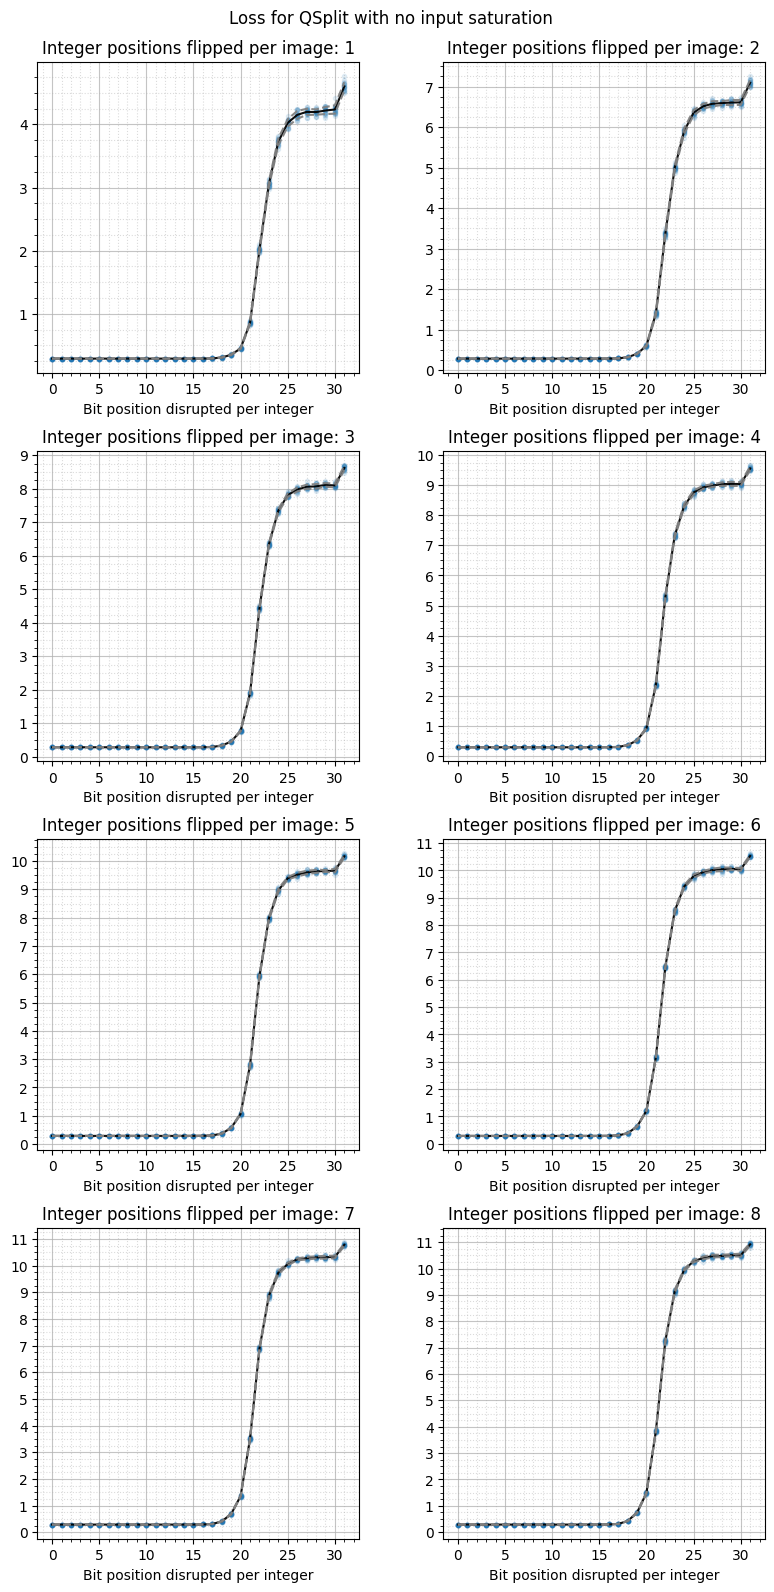

In [5]:
# Loss model: 'final 01' data: 'QSplit_no_input_saturation_2023-05-23.csv'
DATA_PATH = OUTPUTS_DIR + 'QSplit_no_input_saturation_2023-05-23.csv'
SAVE_NAME = 'QSplit No Input Saturation Loss.png'
N_FLIPS = 8
df = pd.read_csv(DATA_PATH)

ax : List[List[plt.Axes]]
fig, ax = plt.subplots(N_FLIPS//2, 2, figsize = (8, 16))
fig.tight_layout(h_pad = 3.5, w_pad = 3.0, rect=[0, 0, 1, 0.96])
fig.suptitle('Loss for QSplit with no input saturation')

for i in range(1, N_FLIPS + 1):
    condition = (df['layer_key'].notna()) & (df['n_bits_flipped'] == i)
    ax[convert_position(i-1)].plot(df.loc[condition]['bit_disrupted'], pd.to_numeric(df.loc[condition]['q_aware_test_loss']), '.', alpha = 0.1)
    ax[convert_position(i-1)].set_title('Integer positions flipped per image: ' + str(i))
    ax[convert_position(i-1)].set_xlabel('Bit position disrupted per integer')
    ax[convert_position(i-1)].xaxis.set_major_locator(ticker.MultipleLocator(5))
    ax[convert_position(i-1)].yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax[convert_position(i-1)].xaxis.set_minor_locator(ticker.AutoMinorLocator(5))
    ax[convert_position(i-1)].yaxis.set_minor_locator(ticker.AutoMinorLocator(4))  
    ax[convert_position(i-1)].grid(which='major', linestyle='-', alpha = 0.75)
    ax[convert_position(i-1)].grid(which='minor', linestyle=':', alpha = 0.45)
    averages = []
    stds = []
    for j in np.unique(df.loc[condition]['bit_disrupted']):
        new_condition = (df['layer_key'].notna()) & (df['n_bits_flipped'] == i) & (df['bit_disrupted'] == j)
        averages.append(pd.to_numeric(df.loc[new_condition]['q_aware_test_loss']).mean())
        stds.append(pd.to_numeric(df.loc[new_condition]['q_aware_test_loss']).std())
    averages = np.array(averages)
    ax[convert_position(i-1)].plot(np.unique(df.loc[condition]['bit_disrupted']), averages, alpha = 0.95, color = 'k')
    ax[convert_position(i-1)].plot(np.unique(df.loc[condition]['bit_disrupted']), (averages + stds), '--', alpha = 0.95, color = 'gray')
    ax[convert_position(i-1)].plot(np.unique(df.loc[condition]['bit_disrupted']), (averages - stds), '--', alpha = 0.95, color = 'gray')

plt.savefig(PLT_SAVE_PATH + SAVE_NAME, bbox_inches = 'tight')
plt.show()
plt.close()

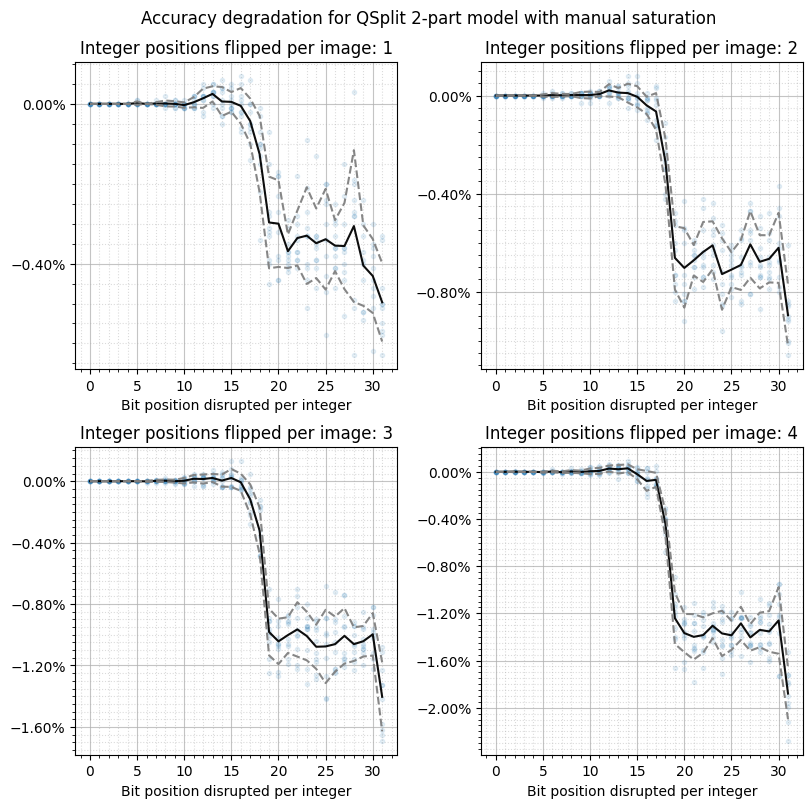

In [8]:
# Accuracy degradation model: 'final 01' data: 'QSplit_manual_saturation_2023-06-29.csv'
DATA_PATH = OUTPUTS_DIR + 'QSplit_manual_saturation_2023-06-29.csv'
SAVE_NAME = 'QSplit Manual Saturation Accuracy 2023-06-29.png'
N_FLIPS = 4
df = pd.read_csv(DATA_PATH)

ax : List[List[plt.Axes]]
fig, ax = plt.subplots(N_FLIPS//2, 2, figsize = (8, 8))
fig.tight_layout(h_pad = 3.5, w_pad = 3.0, rect=[0, 0, 1, 0.94])
fig.suptitle('Accuracy degradation for QSplit 2-part model with manual saturation')

for i in range(1, N_FLIPS + 1):
    ax[convert_position(i-1)].yaxis.set_major_formatter(ticker.PercentFormatter())
    condition = (df['layer_key'].notna()) & (df['n_bits_flipped'] == i)
    ax[convert_position(i-1)].plot(df.loc[condition]['bit_disrupted'], pd.to_numeric(df.loc[condition]['q_aware_test_acc_degradation'])*100, '.', alpha = 0.1)
    ax[convert_position(i-1)].set_title('Integer positions flipped per image: ' + str(i))
    ax[convert_position(i-1)].set_xlabel('Bit position disrupted per integer')
    ax[convert_position(i-1)].xaxis.set_major_locator(ticker.MultipleLocator(5))
    ax[convert_position(i-1)].yaxis.set_major_locator(ticker.MultipleLocator(0.4))
    ax[convert_position(i-1)].xaxis.set_minor_locator(ticker.AutoMinorLocator(5))
    ax[convert_position(i-1)].yaxis.set_minor_locator(ticker.AutoMinorLocator(8)) 
    ax[convert_position(i-1)].grid(which='major', linestyle='-', alpha = 0.75)
    ax[convert_position(i-1)].grid(which='minor', linestyle=':', alpha = 0.45)
    averages = []
    stds = []
    for j in np.unique(df.loc[condition]['bit_disrupted']):
        new_condition = (df['layer_key'].notna()) & (df['n_bits_flipped'] == i) & (df['bit_disrupted'] == j)
        averages.append(pd.to_numeric(df.loc[new_condition]['q_aware_test_acc_degradation']).mean())
        stds.append(pd.to_numeric(df.loc[new_condition]['q_aware_test_acc_degradation']).std())
    averages = np.array(averages)
    ax[convert_position(i-1)].plot(np.unique(df.loc[condition]['bit_disrupted']), averages*100, alpha = 0.95, color = 'k')
    ax[convert_position(i-1)].plot(np.unique(df.loc[condition]['bit_disrupted']), (averages + stds)*100, '--', alpha = 0.95, color = 'gray')
    ax[convert_position(i-1)].plot(np.unique(df.loc[condition]['bit_disrupted']), (averages - stds)*100, '--', alpha = 0.95, color = 'gray')

plt.savefig(PLT_SAVE_PATH + SAVE_NAME, bbox_inches = 'tight')
plt.show()
plt.close()

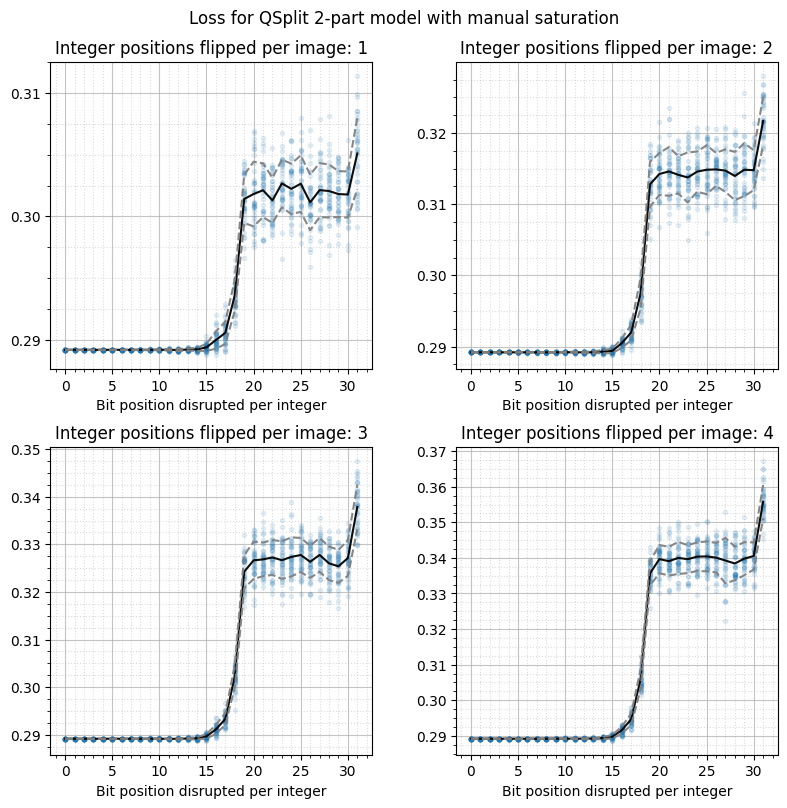

In [7]:
# Loss model: 'final 01' data: 'QSplit_manual_saturation_2023-06-15.csv'
DATA_PATH = OUTPUTS_DIR + 'QSplit_manual_saturation_2023-06-15.csv'
SAVE_NAME = 'QSplit Manual Saturation Loss.png'
N_FLIPS = 4
df = pd.read_csv(DATA_PATH)

ax : List[List[plt.Axes]]
fig, ax = plt.subplots(N_FLIPS//2, 2, figsize = (8, 8))
fig.tight_layout(h_pad = 3.5, w_pad = 3.0, rect=[0, 0, 1, 0.94])
fig.suptitle('Loss for QSplit 2-part model with manual saturation')

for i in range(1, N_FLIPS + 1):
    condition = (df['layer_key'].notna()) & (df['n_bits_flipped'] == i)
    ax[convert_position(i-1)].plot(df.loc[condition]['bit_disrupted'], pd.to_numeric(df.loc[condition]['q_aware_test_loss']), '.', alpha = 0.1)
    ax[convert_position(i-1)].set_title('Integer positions flipped per image: ' + str(i))
    ax[convert_position(i-1)].set_xlabel('Bit position disrupted per integer')
    ax[convert_position(i-1)].xaxis.set_major_locator(ticker.MultipleLocator(5))
    ax[convert_position(i-1)].yaxis.set_major_locator(ticker.MultipleLocator(0.01))
    ax[convert_position(i-1)].xaxis.set_minor_locator(ticker.AutoMinorLocator(5))
    ax[convert_position(i-1)].yaxis.set_minor_locator(ticker.AutoMinorLocator(4))  
    ax[convert_position(i-1)].grid(which='major', linestyle='-', alpha = 0.75)
    ax[convert_position(i-1)].grid(which='minor', linestyle=':', alpha = 0.45)
    averages = []
    stds = []
    for j in np.unique(df.loc[condition]['bit_disrupted']):
        new_condition = (df['layer_key'].notna()) & (df['n_bits_flipped'] == i) & (df['bit_disrupted'] == j)
        averages.append(pd.to_numeric(df.loc[new_condition]['q_aware_test_loss']).mean())
        stds.append(pd.to_numeric(df.loc[new_condition]['q_aware_test_loss']).std())
    averages = np.array(averages)
    ax[convert_position(i-1)].plot(np.unique(df.loc[condition]['bit_disrupted']), averages, alpha = 0.95, color = 'k')
    ax[convert_position(i-1)].plot(np.unique(df.loc[condition]['bit_disrupted']), (averages + stds), '--', alpha = 0.95, color = 'gray')
    ax[convert_position(i-1)].plot(np.unique(df.loc[condition]['bit_disrupted']), (averages - stds), '--', alpha = 0.95, color = 'gray')

plt.savefig(PLT_SAVE_PATH + SAVE_NAME, bbox_inches = 'tight')
plt.show()
plt.close()

In [63]:
# Accuracy degradation model: 'final 01' data: 'QSplit_final_01_multi_relu_2023-06-18.csv'
EXTENSION = 'pgf'
[save_path, fig_size] = pyplot_backend_change(EXTENSION)
print("Matploblib backend:", matplotlib.get_backend())

# Constants and data loading
DATA_PATH = OUTPUTS_DIR + 'QSplit_final_01_multi_relu_2023-06-18.csv'
SAVE_NAME = 'Q_Split_final_multi_acc_degradation.' + EXTENSION
N_FLIPS = 4
df = pd.read_csv(DATA_PATH)

# Graphs definition
ax : List[List[plt.Axes]]
fig, ax = plt.subplots(N_FLIPS//2, 2, figsize = (fig_size, fig_size))
fig.tight_layout(h_pad = 3.5, rect=[0, 0, 1, 1])
# fig.suptitle('Accuracy degradation for QSplit 2-part model with post activation saturation')
yaxis_major_locators = [.2, .4, .5, .8]
yaxis_minors_locators = [4, 4, 4, 2]
decimals = [1, 1, 1, 1]

for i in range(1, N_FLIPS + 1):
    ax[convert_position(i-1)].yaxis.set_major_formatter(ticker.PercentFormatter(decimals = 1))
    condition = (df['layer_key'].notna()) & (df['n_bits_flipped'] == i)
    ax[convert_position(i - 1)].plot(df.loc[condition]['bit_disrupted'], pd.to_numeric(df.loc[condition]['q_aware_test_acc_degradation'])*100, '.', alpha = 0.05, markersize = 4)
    ax[convert_position(i - 1)].set_title('Bits flipped per image: ' + str(i))
    ax[convert_position(i - 1)].set_xlabel('Bit position disrupted per integer')
    ax[convert_position(i - 1)].xaxis.set_major_locator(ticker.MultipleLocator(5))
    ax[convert_position(i - 1)].xaxis.set_minor_locator(ticker.AutoMinorLocator(5))
    ax[convert_position(i - 1)].yaxis.set_major_locator(ticker.MultipleLocator(yaxis_major_locators[i - 1]))
    ax[convert_position(i - 1)].yaxis.set_minor_locator(ticker.AutoMinorLocator(yaxis_minors_locators[i - 1])) 
    ax[convert_position(i - 1)].grid(which='major', linestyle='-', alpha = 0.50, linewidth = 0.50)
    ax[convert_position(i - 1)].grid(which='minor', linestyle=':', alpha = 0.25, linewidth = 0.25)

    # Trend lines
    averages = []
    stds = []
    bits_array = np.unique(df.loc[condition]['bit_disrupted'])
    for j in bits_array:
        new_condition = condition & (df['bit_disrupted'] == j)
        averages.append(pd.to_numeric(df.loc[new_condition]['q_aware_test_acc_degradation']).mean())
        stds.append(pd.to_numeric(df.loc[new_condition]['q_aware_test_acc_degradation']).std())
    averages = np.array(averages)
    ax[convert_position(i - 1)].plot(bits_array, averages*100, alpha = 0.95, color = 'purple', linewidth = 1.5)
    ax[convert_position(i - 1)].plot(bits_array, (averages + stds)*100, '--', alpha = 0.95, color = 'green', linewidth = 0.75)
    ax[convert_position(i - 1)].plot(bits_array, (averages - stds)*100, '--', alpha = 0.95, color = 'green', linewidth = 0.75)

plt.savefig(save_path + SAVE_NAME, bbox_inches = 'tight')
plt.show()
plt.close()

Matploblib backend: pgf


C:\Users\rosal\AppData\Local\Temp\ipykernel_11220\2007473251.py:48: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  plt.show()


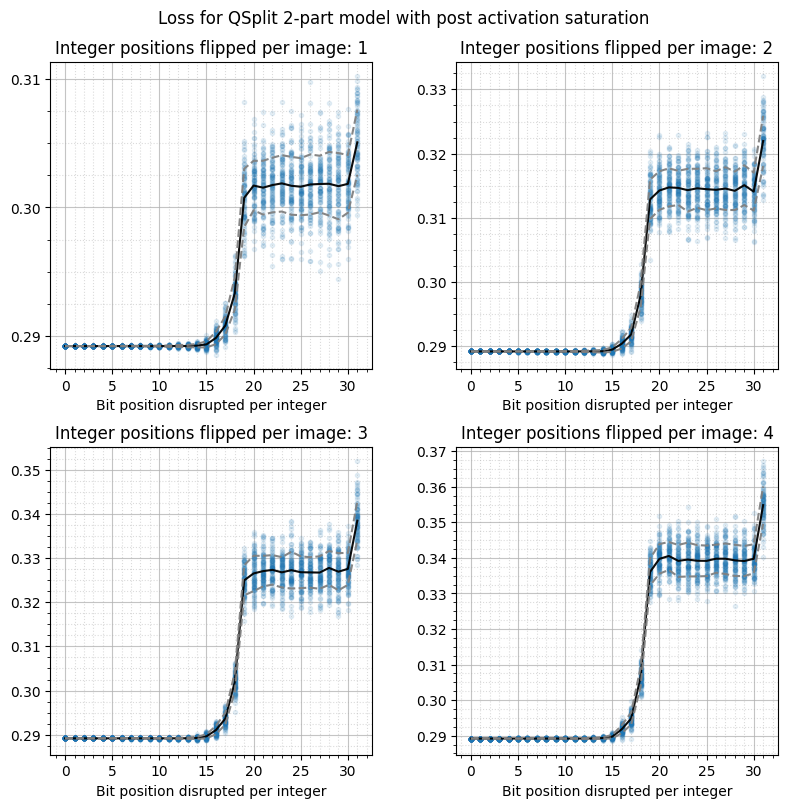

In [7]:
# Loss model: 'final 01' data: 'QSplit_final_01_multi_relu_2023-06-18.csv'
# DATA_PATH = OUTPUTS_DIR + 'QSplit_16-50-58_multi_relu_2023-07-12.csv'
# SAVE_NAME = 'QSplit 16-50-58 Post Activation Saturation Loss.png'
DATA_PATH = OUTPUTS_DIR + 'QSplit_final_01_multi_relu_2023-06-18.csv'
SAVE_NAME = 'QSplit final-01 Post Activation Saturation Loss.png'
N_FLIPS = 4
df = pd.read_csv(DATA_PATH)

ax : List[List[plt.Axes]]
fig, ax = plt.subplots(N_FLIPS//2, 2, figsize = (8, 8))
fig.tight_layout(h_pad = 3.5, w_pad = 3.0, rect=[0, 0, 1, 0.94])
fig.suptitle('Loss for QSplit 2-part model with post activation saturation')

for i in range(1, N_FLIPS + 1):
    condition = (df['layer_key'].notna()) & (df['n_bits_flipped'] == i)
    ax[convert_position(i-1)].plot(df.loc[condition]['bit_disrupted'], pd.to_numeric(df.loc[condition]['q_aware_test_loss']), '.', alpha = 0.1)
    ax[convert_position(i-1)].set_title('Integer positions flipped per image: ' + str(i))
    ax[convert_position(i-1)].set_xlabel('Bit position disrupted per integer')
    ax[convert_position(i-1)].xaxis.set_major_locator(ticker.MultipleLocator(5))
    ax[convert_position(i-1)].yaxis.set_major_locator(ticker.MultipleLocator(0.01))
    ax[convert_position(i-1)].xaxis.set_minor_locator(ticker.AutoMinorLocator(5))
    ax[convert_position(i-1)].yaxis.set_minor_locator(ticker.AutoMinorLocator(4))  
    ax[convert_position(i-1)].grid(which='major', linestyle='-', alpha = 0.75)
    ax[convert_position(i-1)].grid(which='minor', linestyle=':', alpha = 0.45)
    averages = []
    stds = []
    for j in np.unique(df.loc[condition]['bit_disrupted']):
        new_condition = (df['layer_key'].notna()) & (df['n_bits_flipped'] == i) & (df['bit_disrupted'] == j)
        averages.append(pd.to_numeric(df.loc[new_condition]['q_aware_test_loss']).mean())
        stds.append(pd.to_numeric(df.loc[new_condition]['q_aware_test_loss']).std())
    averages = np.array(averages)
    ax[convert_position(i-1)].plot(np.unique(df.loc[condition]['bit_disrupted']), averages, alpha = 0.95, color = 'k')
    ax[convert_position(i-1)].plot(np.unique(df.loc[condition]['bit_disrupted']), (averages + stds), '--', alpha = 0.95, color = 'gray')
    ax[convert_position(i-1)].plot(np.unique(df.loc[condition]['bit_disrupted']), (averages - stds), '--', alpha = 0.95, color = 'gray')

plt.savefig(PLT_SAVE_PATH + SAVE_NAME, bbox_inches = 'tight')
plt.show()
plt.close()

In [43]:
# Accuracy degradation histogram model: 'final 01' data: 'QSplit_m2_quantized_2023-05-22.csv'
EXTENSION = 'pgf'
[save_path, fig_size] = pyplot_backend_change(EXTENSION)
print("Matploblib backend:", matplotlib.get_backend())

# Constants and data loading
DATA_PATH = OUTPUTS_DIR + 'QSplit_m2_quantized_2023-05-22.csv'
SAVE_NAME = 'Q_Split_final_acc_degradation_histogram.' + EXTENSION
df = pd.read_csv(DATA_PATH)

flips_list = [1, 4]
bits_list = [15, 18, 25, 31]
fig, ax = plt.subplots(len(bits_list), len(flips_list), figsize = (fig_size, 3/2*fig_size))
fig.tight_layout(h_pad = 3.5, rect = [0, 0, 1, 1])
# fig.suptitle('Q Aware accuracy degradation histograms')

list_xmax = []
list_xmin = []
list_ymax = []
for column, flip in enumerate(flips_list):
    condition = (df['n_bits_flipped'] == flip) & (df['bit_disrupted'].isin(bits_list))
    list_xmax.append(df.loc[condition]['q_aware_test_acc_degradation'].max())
    list_xmin.append(df.loc[condition]['q_aware_test_acc_degradation'].min())

bin_grid_number = 40
for row, bit in enumerate(bits_list):
    for column, flip in enumerate(flips_list):
        ax[row,column].xaxis.set_major_formatter(ticker.PercentFormatter(decimals = 1))
        condition = (df['layer_key'].notna()) & (df['n_bits_flipped'] == flip) & (df['bit_disrupted'] == bit)
        data = pd.to_numeric(df.loc[condition]['q_aware_test_acc_degradation'])*100
        binwidth = (list_xmax[column] - list_xmin[column])*100/bin_grid_number
        [values, bins, patches] = ax[row,column].hist(data, bins = np.arange(min(data), max(data) + binwidth, binwidth), density = True)
        list_ymax.append(values.max())
        ax[row,column].set_xlabel('Accuracy degradation')
        ax[row,column].grid()
        ax[row,column].grid(which = 'major', linestyle = '-', alpha = 0.50, linewidth = 0.5)
        ax[row,column].legend(['Bit affected ' + str(bit)])
        ax[row,column].set_title('Number of bits flipped ' + str(flip))
        ax[row,column].set_xlim([list_xmin[column]*100 - binwidth, list_xmax[column]*100 + binwidth])
        
for row, bit in enumerate(bits_list):
    for column, flip in enumerate(flips_list):
        ax[row,column].set_ylim([0, 1.025*np.max(list_ymax)])

plt.savefig(save_path + SAVE_NAME, bbox_inches = 'tight')
plt.show()
plt.close()

Matploblib backend: pgf


C:\Users\rosal\AppData\Local\Temp\ipykernel_11220\656610219.py:46: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  plt.show()


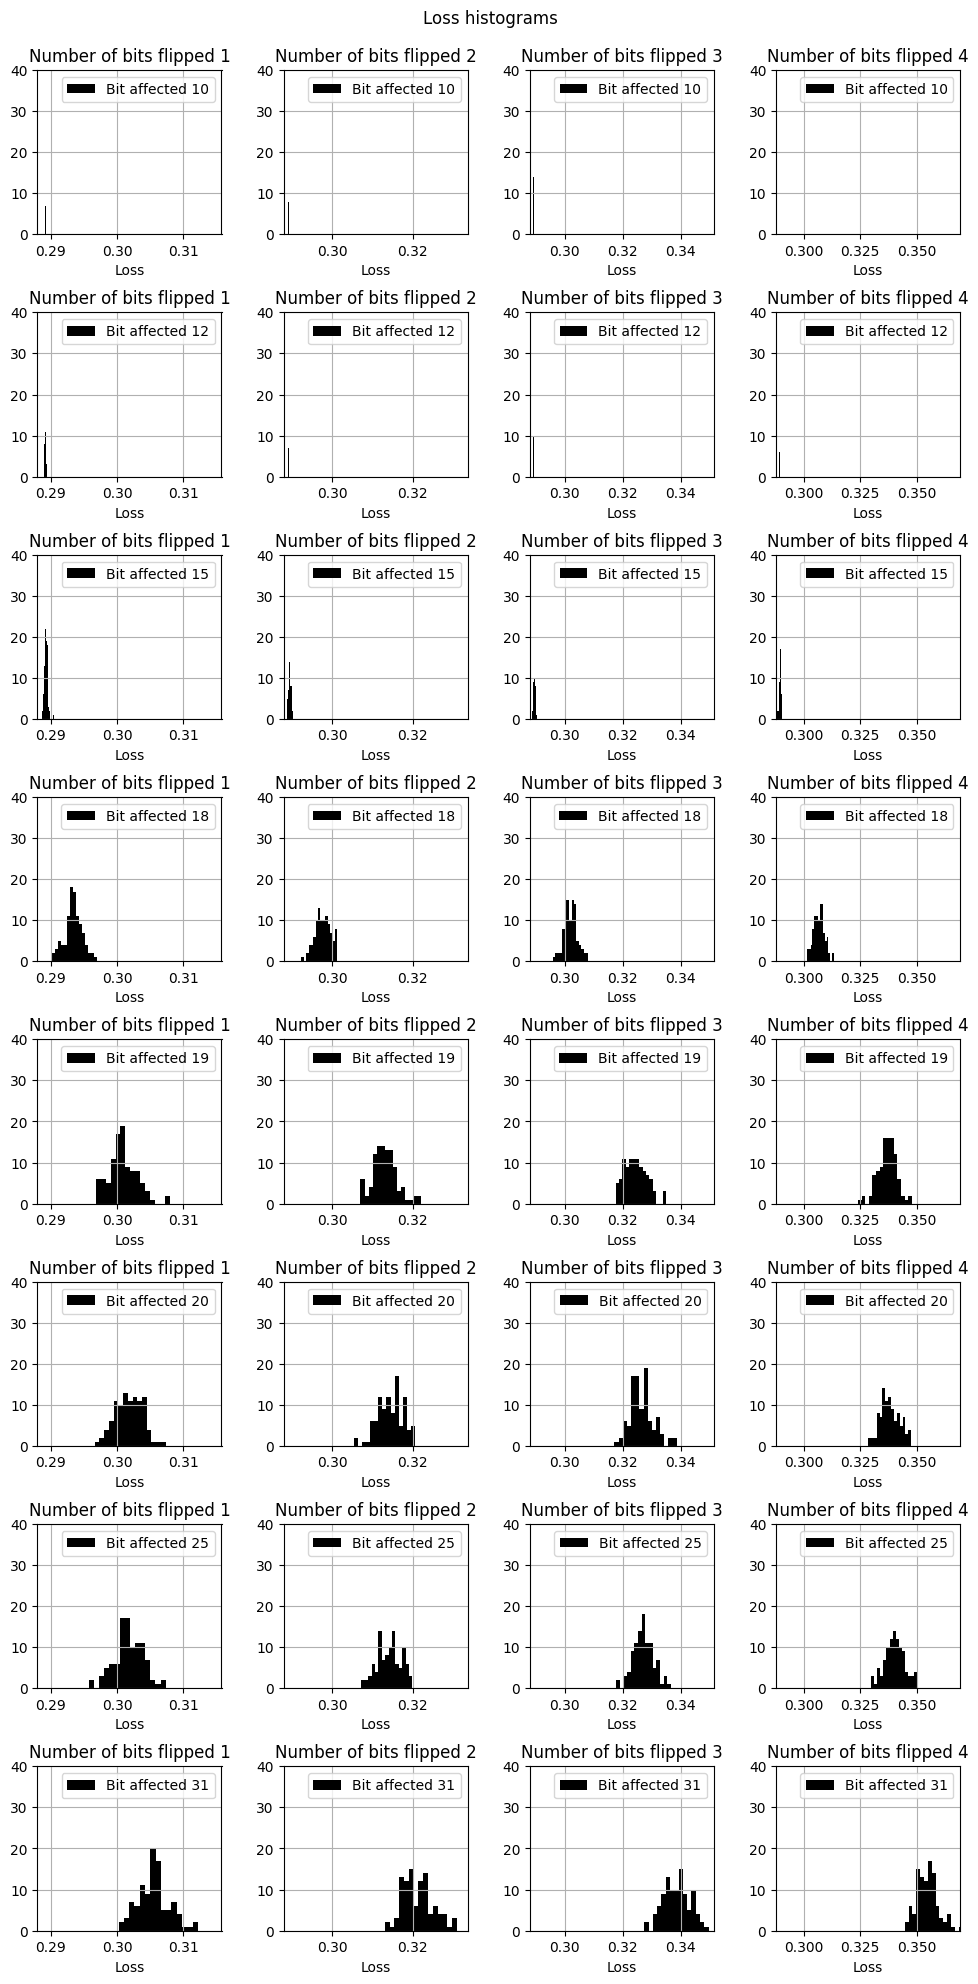

In [11]:
# Accuracy degradation histogram model: 'final 01' data: 'QSplit_m2_quantized_2023-05-22.csv'
DATA_PATH = OUTPUTS_DIR + 'QSplit_m2_quantized_2023-05-22.csv'
SAVE_NAME = 'QSplit Model-2 Loss histogram.png'
N_FLIPS = 4

df = pd.read_csv(DATA_PATH)

bits_list = [10,12,15,18,19,20,25,31]
fig, ax = plt.subplots(N_GRAPHS, N_FLIPS, figsize = (10, 20))
fig.tight_layout(h_pad = 3.5, rect = [0, 0, 1, 0.96])
fig.suptitle('Loss histograms')

for row in range(len(bits_list)):
    for column in range(N_FLIPS):
        condition = (df['layer_key'].notna()) & (df['n_bits_flipped'] == column + 1) & (df['bit_disrupted'] == bits_list[row])
        ax[row,column].hist(pd.to_numeric(df.loc[condition]['q_aware_test_loss']), bins = 15, color = 'k')
        ax[row,column].set_xlabel('Loss')
        ax[row,column].grid()
        ax[row,column].legend(['Bit affected ' + str(bits_list[row])])
        ax[row,column].set_title('Number of bits flipped ' + str(column + 1))
        ax[row,column].set_xlim([0.288 - 2.8e-5*(column + 1), 0.298 + .0178*(column + 1)])
        ax[row,column].set_ylim([0, 40])

plt.savefig(PLT_SAVE_PATH + SAVE_NAME, bbox_inches = 'tight')
plt.show()
plt.close()

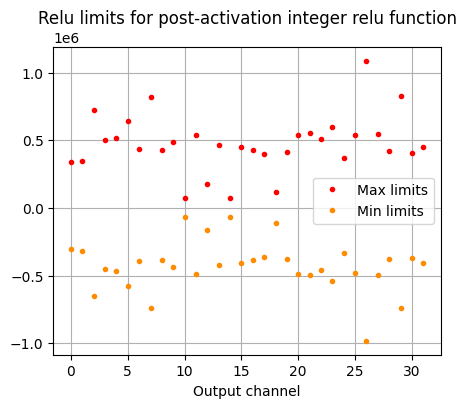

In [4]:
# Weights limits graph model: 'final 01' 
LOAD_PATH_Q_AWARE = "./model/model_q_aware_final_01"
DATA_PATH = OUTPUTS_DIR + 'QSplit_m2_quantized_2023-05-22.csv'
SAVE_NAME = 'Post activation Limits.png'

# Load Q Aware model
with tfmot.quantization.keras.quantize_scope():
    q_aware_model : Functional = tf.keras.models.load_model(LOAD_PATH_Q_AWARE)
q_model_info = Quantization.QuantizedModelInfo(q_aware_model)
import typing
index = 1
key = q_model_info.keys[index]
channels = q_model_info.output_shapes[key][-1]

fig, ax = plt.subplots(1, 1, figsize = (5, 4))
# fig.tight_layout(h_pad = 1.5, rect=[0, 0, 1, 0.93])
# fig.suptitle('Relu limits for pos activation integer relu function')

ax.set_title('Relu limits for post-activation integer relu function')
ax.plot(q_model_info.quantized_post_activ_max[key], '.', color = 'red', label = 'Max limits')
ax.plot(q_model_info.quantized_post_activ_min[key], '.', color = 'darkorange', label = 'Min limits')
ax.set_xlabel('Output channel')
ax.grid()
ax.legend()

plt.savefig(PLT_SAVE_PATH + SAVE_NAME, bbox_inches = 'tight')
plt.show()
plt.close()

In [71]:
# Accuracy degradation model: 'ep5 16-50-58' data: 'QSplit_16-50-58_multi_relu_2023-07-12.csv'
EXTENSION = 'pgf'
[save_path, fig_size] = pyplot_backend_change(EXTENSION)
print("Matploblib backend:", matplotlib.get_backend())

# Constants and data loading
DATA_PATH = OUTPUTS_DIR + 'QSplit_16-50-58_multi_relu_2023-07-12.csv'
SAVE_NAME = 'Q_Split_ep5_multi_acc_degradation.' + EXTENSION
N_FLIPS = 4
df = pd.read_csv(DATA_PATH)

# Graphs definition
ax : List[List[plt.Axes]]
fig, ax = plt.subplots(N_FLIPS//2, 2, figsize = (fig_size, fig_size))
fig.tight_layout(h_pad = 3.5, rect=[0, 0, 1, 1])
# fig.suptitle('Accuracy degradation for QSplit 2-part model with post activation saturation')
yaxis_major_locators = [.2, .4, .5, .8]
yaxis_minors_locators = [4, 4, 4, 2]
decimals = [1, 1, 1, 1]

for i in range(1, N_FLIPS + 1):
    ax[convert_position(i-1)].yaxis.set_major_formatter(ticker.PercentFormatter(decimals = 1))
    condition = (df['layer_key'].notna()) & (df['n_bits_flipped'] == i)
    ax[convert_position(i-1)].plot(df.loc[condition]['bit_disrupted'], pd.to_numeric(df.loc[condition]['q_aware_test_acc_degradation'])*100, '.', alpha = 0.05, markersize = 4)
    ax[convert_position(i-1)].set_title('Bits flipped per image: ' + str(i))
    ax[convert_position(i-1)].set_xlabel('Bit position disrupted per integer')
    ax[convert_position(i-1)].xaxis.set_major_locator(ticker.MultipleLocator(5))
    ax[convert_position(i-1)].xaxis.set_minor_locator(ticker.AutoMinorLocator(5))
    ax[convert_position(i-1)].yaxis.set_major_locator(ticker.MultipleLocator(yaxis_major_locators[i - 1]))
    ax[convert_position(i-1)].yaxis.set_minor_locator(ticker.AutoMinorLocator(yaxis_minors_locators[i - 1])) 
    ax[convert_position(i-1)].grid(which='major', linestyle='-', alpha = 0.50, linewidth = 0.50)
    ax[convert_position(i-1)].grid(which='minor', linestyle=':', alpha = 0.25, linewidth = 0.25)
    
    # Trend lines
    averages = []
    stds = []
    bits_array = np.unique(df.loc[condition]['bit_disrupted'])
    for j in bits_array:
        new_condition = condition & (df['bit_disrupted'] == j)
        averages.append(pd.to_numeric(df.loc[new_condition]['q_aware_test_acc_degradation']).mean())
        stds.append(pd.to_numeric(df.loc[new_condition]['q_aware_test_acc_degradation']).std())
    averages = np.array(averages)
    ax[convert_position(i-1)].plot(bits_array, averages*100, alpha = 0.95, color = 'purple', linewidth = 1.5)
    ax[convert_position(i-1)].plot(bits_array, (averages + stds)*100, '--', alpha = 0.95, color = 'green', linewidth = 0.75)
    ax[convert_position(i-1)].plot(bits_array, (averages - stds)*100, '--', alpha = 0.95, color = 'green', linewidth = 0.75)

plt.savefig(save_path + SAVE_NAME, bbox_inches = 'tight')
plt.show()
plt.close()

Matploblib backend: pgf


C:\Users\rosal\AppData\Local\Temp\ipykernel_11220\2051698758.py:48: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  plt.show()
